In [22]:
%reload_ext autoreload
%autoreload 2

# 0.01: Evaluating Quantile Regression MIA

We compute the true positive rate and false positive rate of the quantile regression MIA on heldout data. First we load the model and evaluation data.

In [21]:
from quantile_diffusion_mia.config import DATASET_CONFIG, MODEL_CONFIG

dataset_name = "CIFAR10"
config = DATASET_CONFIG[dataset_name]

import torch
from quantile_diffusion_mia.modeling.train import load_quantile_model
import numpy as np
from quantile_diffusion_mia.dataset import QuantileRegressionDataset

# Load the model
model_dir = "../" + config["quantile_regression_model_path"]
model = load_quantile_model(model_dir, alpha=0.01).to("cuda")

# Load the eval indices
split_path = "../" + config['quantile_regression_split_path']
output = np.load(split_path)
quantile_eval_indices = output['quantile_eval_indices']

# Load the dataset
data_path = "../" + config['quantile_regression_data_path']
eval_dataset = QuantileRegressionDataset.load(data_path)
eval_dataset.set_indices(quantile_eval_indices)

In [23]:
from torch.utils.data import DataLoader
import pandas as pd

config = MODEL_CONFIG[f'{dataset_name}_QUANTILE']
model.eval()
results = []

eval_loader = DataLoader(eval_dataset, batch_size=config['batch_size'], shuffle=False, num_workers=4)

with torch.no_grad():
    for data in eval_loader:
        original_images, reconstructed_images, targets, labels = data
        features = torch.cat((original_images, reconstructed_images), dim=1).to("cuda")
        predictions = model(features).squeeze().cpu().numpy()
        targets = (targets * 10**10).cpu().numpy()
        results.extend(zip(predictions, targets, labels))

results_df = pd.DataFrame(results, columns=['Predicted', 'Actual', 'Label'])
print(results_df)

       Predicted    Actual      Label
0       0.573993  0.446279     member
1       0.555950  0.316099     member
2       0.539952  0.323373     member
3       0.454884  0.563568     member
4       0.681522  0.705712     member
...          ...       ...        ...
37495   0.492489  0.803564  nonmember
37496   0.664852  1.483810  nonmember
37497   0.782320  1.453525  nonmember
37498   0.693354  0.992047  nonmember
37499   0.782891  1.410499  nonmember

[37500 rows x 3 columns]


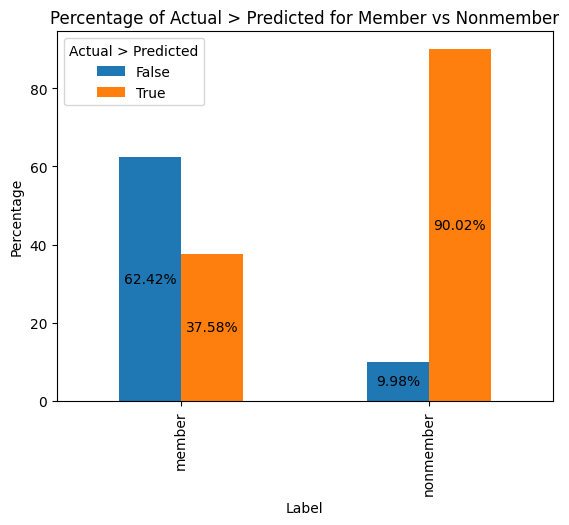

In [24]:
import matplotlib.pyplot as plt

# Create a new column to indicate if actual > predicted
results_df['Actual > Predicted'] = results_df['Actual'] > results_df['Predicted']

# Group by 'Label' and 'Actual > Predicted' and count the occurrences
grouped = results_df.groupby(['Label', 'Actual > Predicted']).size().unstack(fill_value=0)

# Convert counts to percentages
grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

# Plot the bar plot
ax = grouped_percentage.plot(kind='bar', stacked=False)
plt.title('Percentage of Actual > Predicted for Member vs Nonmember')
plt.xlabel('Label')
plt.ylabel('Percentage')

# Add labels on the bars
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x + width / 2, y + height / 2, f'{height:.2f}%', ha='center', va='center')

plt.show()